**TIME SERIES ANALYSIS FOR STOCK MARKET DATA SPECIFICALLY AMAZON. DATA SOURCE IS YAHOO.API AND ALPHADVANTAGE.API**

**This notebook is Part 1 of Time series modelling for Amazon Stock Prediction
It deals with:**

**1.   Data Exploration**

**2.   Making a time series window**

**3.   Feature engineering from the data**

**4. Make an ARIMA model**

**5. Make a Fourier series mode**l

**6. Make a LSTM model with one feature**

**7.Make a LSTM model with multiple features**

**8.Conclusion**





**Level 0: INSTALLATION**

**1.   Set up modules on google colab**

**2.  Take in data from yahoo.api**

**3. For privacy of my own account I have blocked these links and API keys off**

**Hint: Google colab Python 3 version comes with all Python packages and modules. It's easier to use than Anaconda or Ubuntu and has a great GPU drive.** 





In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Use the code above to set up Drive which will have csv file.**

Credit: https://medium.com/paper-club/how-to-set-up-google-colab-colaboratory-for-building-pyro-models-8e51129e772a

In [0]:
link = 'https://drive.google.com/open?id=1y394o-wiPqYPaWzVYTPRr8xpE_aM9621'

**Link to your google drive. This will make your drive public to all so be careful who you give it to.**

In [12]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1y394o-wiPqYPaWzVYTPRr8xpE_aM9621


**To check I got data in my file and it's been read**

In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')
# Dataset is now stored in a Pandas Dataframe

In [14]:
pip install mxnet

**install mxnet a python package for time series data great for visualization**

In [0]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

Setting up mxnet model 
Need this to create an ARIMA model and Fourier series model easily 

In [0]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

**Always sort time and format it properily for time series data. Here sorted out it month-date-year format.** 

In [0]:
import pandas as pd

In [0]:
dataset_ex_df = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [21]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,133.899994
1,2010-01-05,134.690002
2,2010-01-06,132.250000


**Have a good look at closing prices and date. Most time series analysis go with trying to fo find closing prices.** 
**The reason is because closing prices generally summarize the way business was going better than opening prices or average prices.**
**Below is a great article to understand stock markets better**
https://medium.com/s/story/predicting-the-stock-market-is-easier-than-you-might-think-4f1e0bc05cfe

In [22]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2265 number of days in the dataset.


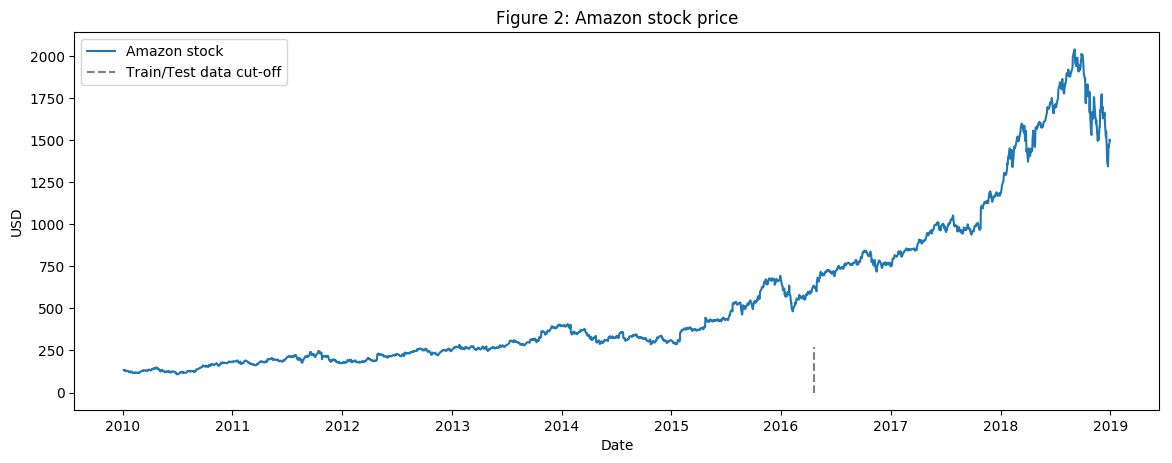

In [23]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Amazon stock')
plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()


**I have divided the stock data after 2010 upto 2019 for Amazon. 
Amazon business really boomed after 2010 and then peaked after 2015 so the testing will be very interesting since most of the data is in the exponential growth period. What I am going to do it normalize the training data such that similar data points over time are reduced to one single data point so that the model can train in such a way it can expect the exponential growth after 2015.**

**Inorder to predict better i NEED TO GENERATOR FEATURES SO I HAVE MORE INDICATORS TO PREDICT THE DATA**

# **FEATURE GENERATION**

In [0]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

**List of technical indicators and explanation:**


**1.   Bollinger bands: Bollinger Bands is used to define the prevailing high and low prices in a market to characterize the trading band of a financial instrument or commodity. Bollinger Bands are a volatility indicator. Bands are consists of Moving Average (MA) line, a upper band and lower band. The upper and lower bands are simply MA adding and subtracting standard deviation.** 

**2.   EMA: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1**
**(the company crashed on 4th day) the average would be 23. Now 23 is a below average value so it gives us an idea that 45 was indeed just a fluke and that infact the company was always making losses**
**EMA is calculated as:**
**EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0)**
**where** 
**α=1L+1 and length of window is α=2M+1**
**I used the ewm(exponential weighted mean ) function to calculate ema.**



**3. Momentum: Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.**

**The formula for momentum is:**

**Momentum=V−Vx**
**where:**

**V=Latest price**

**Vx=Closing price**

**x=Number of days ago**


**Other features calculated are**
**moving averages of 7 and 21 days and standard deviation.**


**Great Links are:**
1. https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/
2. https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861

In [0]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [26]:
dataset_TI_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,NaN,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,NaN,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,NaN,NaN,133.520004,NaN


In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

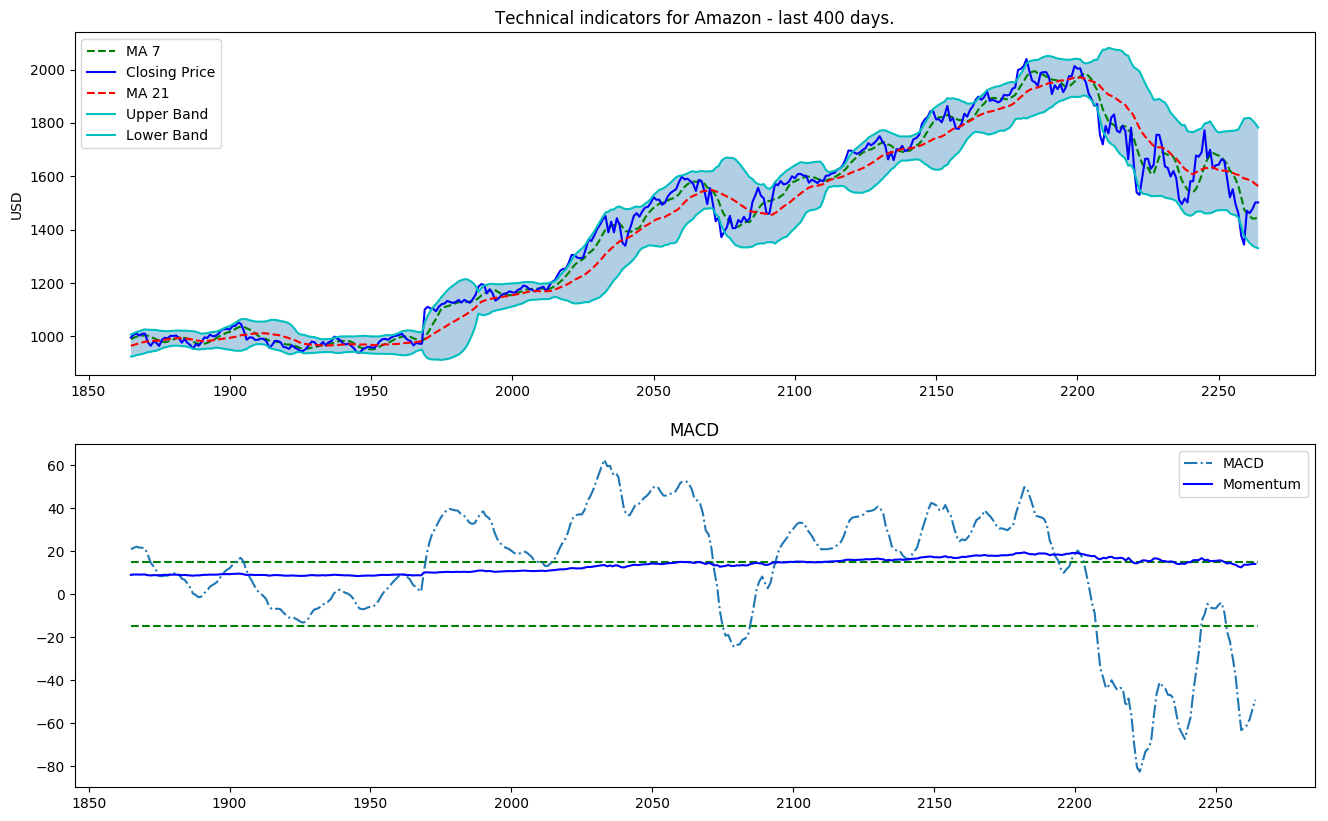

In [28]:
plot_technical_indicators(dataset_TI_df, 400)

**PLOT UNDERSTANDING:** 

**THE FIRST PLOT IS SELF EXPLANATORY**

**THE SECOND PLOT IS SHOWING THE THRESHOLD BETWEEN MACD AND MOMENTUM. AS YOU CAN SEE MOMENTUM IS GIVING AN AVERAGE VALUE OF THE MACD IN BETEEEN THE PEAK VALUES AND THE HIGHEST OR LOWEST VALUES. MACD DEPENDS ON THE MOVING AVERAGE FEATURES AS CALCULATED ABOVE**



>  
# **ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM**




In [0]:
data_FT = dataset_ex_df[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

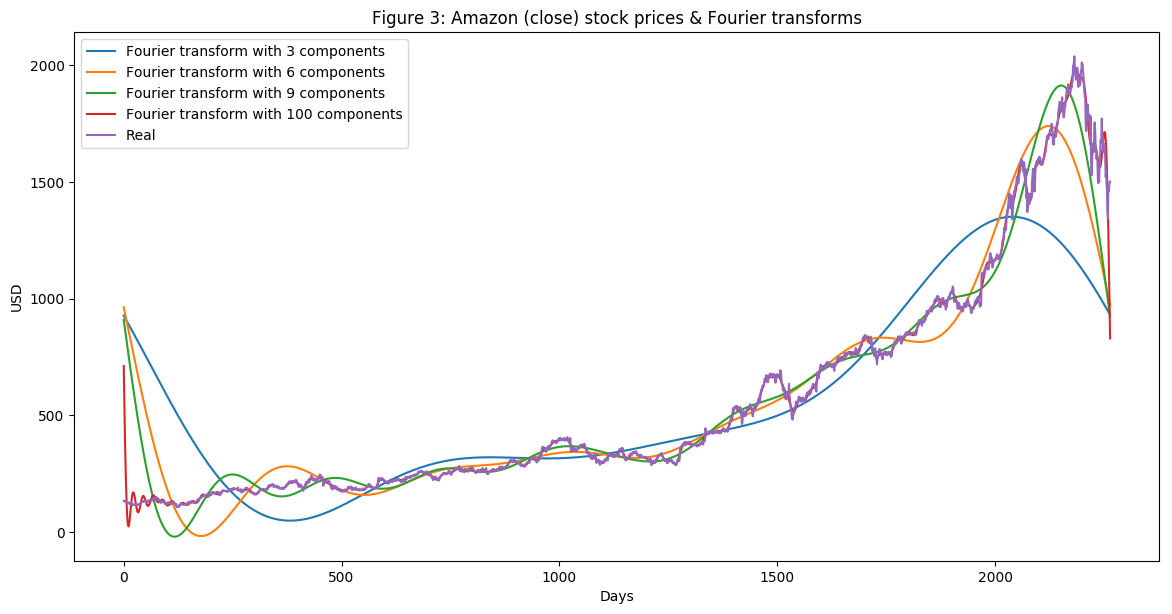

In [30]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


**Fourier Transform uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it's reconverted into time domain where it's plotted.**
**Fourier Transform as indicator helps to extract predominate cycle from a series of data**

**Reference: https://www.metastock.com/customer/resources/taaz/?p=58**

**In the above example we can see the spectral component of 100 is closest to the real price so we will move ahead ith 100**




In [0]:

def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [0]:
dataset_TI_df = get_fourier(dataset_ex_df)

In [33]:
dataset_TI_df.head(30)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,NaN,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,NaN,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,NaN,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,NaN,129.110001,NaN
8,2010-01-14,129.139999,130.380005,126.400002,127.349998,9774900,129.984286,NaN,130.496376,129.999802,-0.496574,NaN,NaN,NaN,127.879659,0.2735,127.349998,NaN,127.349998,NaN
9,2010-01-15,129.179993,129.649994,127.059998,127.139999,15376500,129.254285,NaN,130.033228,129.457870,-0.575358,NaN,NaN,NaN,127.386544,0.2714,127.139999,NaN,127.139999,NaN


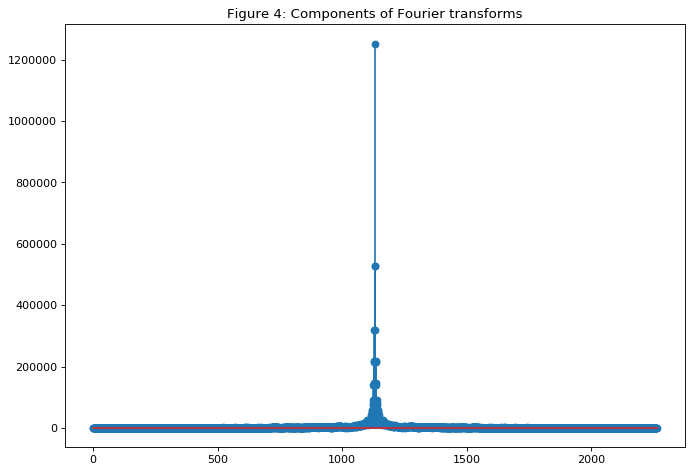

In [34]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

**Component analysis of Fourier Transform**
**Once the spectral part of Fourier transform is removed the magnitude part is quite close to the test series values!** 
**Fourier transform is working!**

# **ARIMA**

 **ARIMA as a feature:**
   
 **Autoregressive Integrated Moving Average (ARIMA) — This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). Let’s add it and see if it comes off as an important predictive feature.**
   
  **ARIMA is a technique for predicting time series data. We will show how to use it, and all though ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.**
  
  **ARIMA is an acronym. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:**

**1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.**

**2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.**

**3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.**

**The parameters of the ARIMA model are defined as follows:**

**p: The number of lag observations included in the model, also called the lag order.**
**d: The number of times that the raw observations are differenced, also called the degree of differencing.**
**q: The size of the moving average window, also called the order of moving average.**

**STEPS FOR ARIMA**

**1.Define the model by calling ARIMA() and passing in the p, d, and q parameters.**

**2. The model is prepared on the training data by calling the fit() function.**

**3.Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.**
 
**First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.**

**When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.**

**Running the example prints a summary of the fit model. This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.**





In [35]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9244.973
Method:                       css-mle   S.D. of innovations             14.361
Date:                Fri, 16 Aug 2019   AIC                          18503.947
Time:                        17:13:56   BIC                          18544.021
Sample:                             1   HQIC                         18518.569
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6074      0.291      2.086      0.037       0.037       1.178
ar.L1.D.Close    -0.0270      0.021     -1.287      0.198      -0.068       0.014
ar.L2.D.Close    -0.0002      0.021     

 **SUMMARY OF THE ARIMA MODEL**
 
**A good starting point for the AR parameter of the model may be 5 which we did**

**From the summary of the ARIMA we can see that most P-values are greater than 0.05 other than the last two.The model should be great!**

**The difference between AIC and BIC is low so this indicates this is a good model**

**Running the example, we can see that there is a positive correlation with the first 0-to-500 lags that is perhaps significant for the first 250 lags in the autocorrelation below**



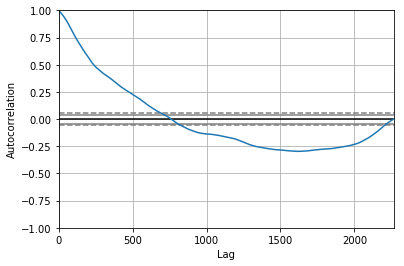

<Figure size 800x560 with 0 Axes>

In [36]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

**Refernce to ARIMA code:**

https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56

https://github.com/gmonaci/ARIMA

**ARIMA Explantion :**

https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56




In [0]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

In [38]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 557.865


MSE issquare root of square of average of difference between actual and predicted prices. In this case they MSE is quite big.(MSE ideally for this data should be between 30 and 100). However I will plot the model and check

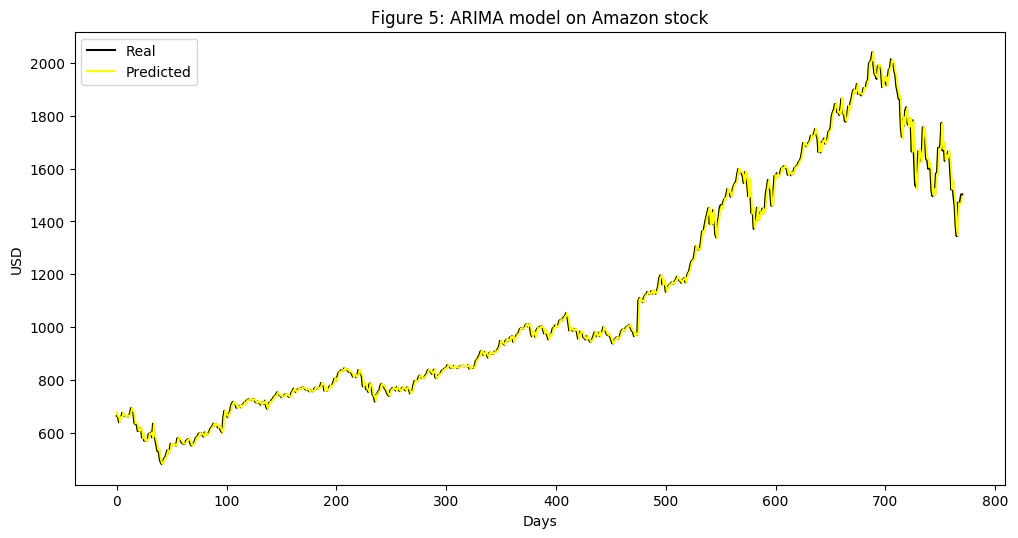

In [39]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()

**As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because, as we mentioned before, we want to capture as many features and patterns about Amazon as possible.**

In [40]:
dataset_ex_df.head(8)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,678.303785,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,664.043069,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,663.388476,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,640.204421,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.576572,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.990696,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.445680,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,669.110595,129.110001,NaN


In [41]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Total dataset has 2265 samples, and 20 features.


# **FINDING IMPORTANT FEATURES USING XGBOOST :**

**Having so many features we have to consider whether all of them are really indicative of the direction GS stock will take. For example, we included USD denominated LIBOR rates in the dataset because we think that changes in LIBOR might indicate changes in the economy, that, in turn, might indicate changes in the AMZN stock behavior. But we need to test. There are many ways to test feature importance, but the one we will apply uses XGBoost, because it gives one of the best results in both classification and regression problems.**


**Since the features dataset is quite large, for the purpose of the presentation here we’ll use only the technical indicators. During the real features importance testing all selected features proved somewhat important so we won’t exclude anything when training.**


**So, after adding all types of data (the correlated assets, technical indicators, fundamental analysis, Fourier, and Arima) we have a total of 20 features for the 2,265 days (as mentioned before, however, only 1,585 days are for training data).**

**What is XGBoost?**

**XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.**

![alt text](https://miro.medium.com/max/1094/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg)

**WHY DOES XGBOOST WORK SO WELL?
XGBoost and Gradient Boosting Machines (GBMs) are both ensemble tree methods that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. However, XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements.**

![alt text](https://miro.medium.com/max/1094/1*FLshv-wVDfu-i54OqvZdHg.png)



In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [0]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)


In [0]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [45]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[17:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
eval_result = regressor.evals_result()

In [0]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

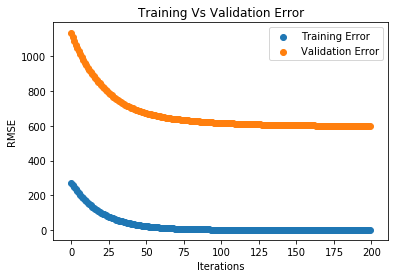

In [48]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

**THE DIFFERENCE BETWEEN VALIDATION AND TRAINING ERROR SHOWS A UNDERFIT MODEL. EXPECTED AS SAID BEFORE BECAUSE OF THE WAY TRAINING AND TESTING DATA IS SPLIT JUST WHEN AMAZON BOOMS!**

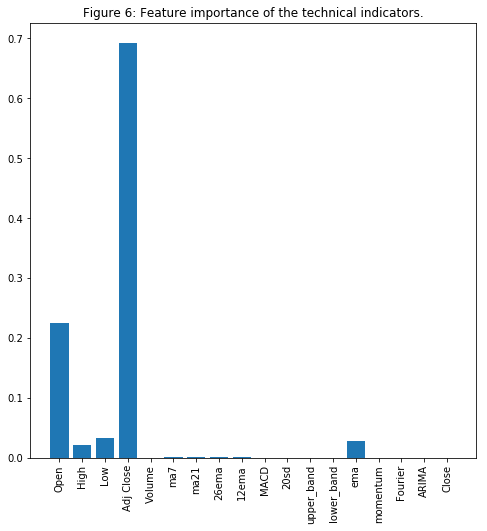

In [49]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

**Not surprisingly (for those with experience in stock trading) that MA7, MA21, and EMA are among the important features.
I followed the same logic for performing feature importance over the whole dataset — just the training took longer and results were a little more difficult to read, as compared with just a handful of features.
Features like Open and Adj Close are bound to be close to Closing prices
So if EMA doesn't works out we will focus on Averaging prices from Open and Adj-CLose prices**


**Next steps:
We know which features are important. I suspect Fourier and ARIMA might be equally important but because of their
spectral component Fourier and because ARIMA doesn't produce any other features I won't be consideringthem.**

Code Ref for XGBoost:
1. https://xgboost.readthedocs.io/en/latest/get_started.html
2. https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

# **LSTM**

**LSTM is great at predicting stock market data. We are going to try to predict the closing prices using 1 feature Open(It has highest correlation to closing price) initially and then using multiple features(use some sort of one hot encoding) and then try to get a output.**

**An LSTM Network has its origin in a RNN. But it can solve the memory loss by changing the neuron architecture.**

![alt text](https://miro.medium.com/max/875/1*8nFrwolzTYtUWSaziiJGkg.png)

**The new neuron has 3 gates, each with a different goal. The gates are:**

**1.Input Gate**

**2.Output Gate**

**3.Forget Gate**

**An LSTM Neuron still receives as input its previous state:**

**LSTM Neuron passing as parameter its previous state.**

![alt text](https://miro.medium.com/max/875/1*J5W8FrASMi93Z81NlAui4w.png)


**Following steps are done:**

**1.  Clean up the data-Remove any NAs**

**2.   Create a test, train and validate set**

**3.   Create train for Open**

**4.   Normalize data** 

**5.Create feature and label set**

**6. Train, test data and  check with validation set**

**7. Make a prediction**

**8. Based on this prediction find if the feature extraction method of LSTM works**



In [50]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_TI_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,678.303785,133.899994,NaN
1,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,664.043069,134.690002,NaN
2,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,663.388476,132.250000,NaN
3,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,640.204421,130.000000,NaN
4,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.576572,133.520004,NaN
5,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.990696,130.309998,NaN
6,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.445680,127.349998,NaN


In [51]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 2265 samples, and 19 features.


In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

Using TensorFlow backend.


In [0]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

**Split dataset into train,test and validate sets**

In [0]:
open_training = train.iloc[:, 1:2].values

**Normalize data:
The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. Use a range to keep values similar for that much range**

**Keep a window for the length 2000 for your data between 50 and 500...since our length is slightly more than 2000 ill make it 60 to 450**

In [0]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])
    
#Code ref: https://github.com/LiamConnell/deep-algotrading

**Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands**

In [0]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [57]:
#training it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))


W0816 17:26:38.344084 139733778487168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 17:26:38.400182 139733778487168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 17:26:38.408069 139733778487168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 17:26:38.632785 139733778487168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0816 17:26:38.642064 

Train on 390 samples, validate on 390 samples
Epoch 1/100
390/390 [==============================] - 9s 23ms/step - loss: 0.0847 - mean_absolute_error: 0.2147 - val_loss: 0.0723 - val_mean_absolute_error: 0.1844
Epoch 2/100
390/390 [==============================] - 4s 11ms/step - loss: 0.0664 - mean_absolute_error: 0.1909 - val_loss: 0.0704 - val_mean_absolute_error: 0.2252
Epoch 3/100
390/390 [==============================] - 4s 11ms/step - loss: 0.0680 - mean_absolute_error: 0.2016 - val_loss: 0.0652 - val_mean_absolute_error: 0.1994
Epoch 4/100
390/390 [==============================] - 4s 11ms/step - loss: 0.0649 - mean_absolute_error: 0.1988 - val_loss: 0.0656 - val_mean_absolute_error: 0.2087
Epoch 5/100
390/390 [==============================] - 4s 11ms/step - loss: 0.0667 - mean_absolute_error: 0.2093 - val_loss: 0.0656 - val_mean_absolute_error: 0.1939
Epoch 6/100
390/390 [==============================] - 4s 11ms/step - loss: 0.0663 - mean_absolute_error: 0.2035 - val_loss:

**MAE: This means the average difference between input and ouput for all 2265 datapoints is 0.167. 
However the value is for the days here so the MAE here is pretty bad.(2265 length of dataset will be denominator. Difference between actual and prediced values should be so small that such a large denominator dividing the difference should put MAE in rage of 10^-3 ie 0.00then digits. Since MAE is 167.something*10^-3(0.167) difference is high**


**Data is trained for 100 epochs optimizer is adam and loss is mse. This seems to be an average model because mean absolute error is 0.18 and val mean absolute eroor is 0.17 so it indicates overfitting. Since this is a regression problem accuracy is not a good metric. MAE was chosen since the difference between training and testing should be less so we don't need to take the square root of the value.** 

**We will focus on hyperparameters if this model is good at prediction**

In [0]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

**Test the model on test data**

In [0]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

**Start predictions:
Reshape, scale and then oredict the model**

In [0]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [0]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [0]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [0]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [0]:
#make predictions
predictions = model.predict(test_features)

In [0]:
predictions = scaler.inverse_transform(predictions)

**Plot the prediction model for the number of test days and train days**

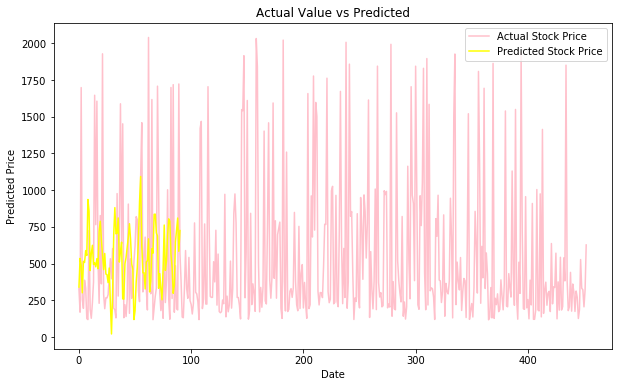

In [66]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


**This wasn't a great result with one feature so let's try using more features and then train them on LSTM model**

**USING 5FEATURES :**


**USING THE BEST 5 FEATURES FROM THE RESULT OF THE XGBOOST. ITS QUITE OBVIOUS THAT A SINGLE FEATURE WILL NOT WORK SO WE USE THE 6 FEATURES THAT
COULD GENERATE THE BEST OUTCOME FROM XGBOOST**

In [0]:
dataset = dataset_ex_df[['Open', 'Close','High','Adj Close','Low']]

In [68]:
dataset.head()

,Open,Close,High,Adj Close,Low
0,136.250000,133.899994,136.610001,133.899994,133.139999
1,133.429993,134.690002,135.479996,134.690002,131.809998
2,134.600006,132.250000,134.729996,132.250000,131.649994
3,132.009995,130.000000,132.320007,130.000000,128.800003
4,130.559998,133.520004,133.679993,133.520004,129.029999


In [0]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [0]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


In [0]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [0]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])

In [0]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [0]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

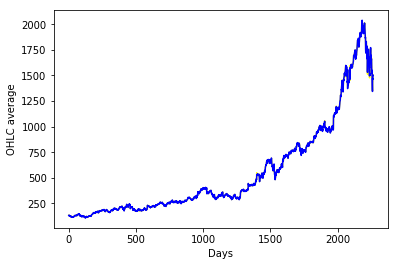

In [75]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()


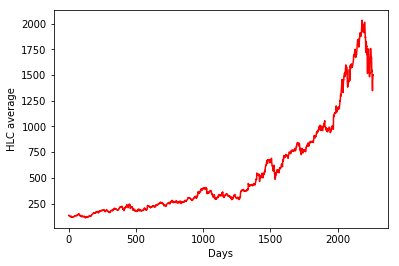

In [76]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()


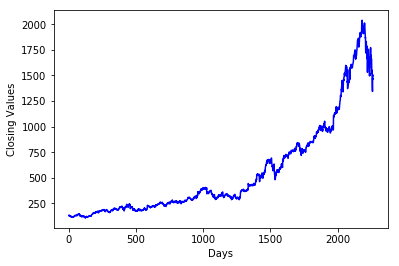

In [77]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [0]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [0]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [0]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [0]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1


In [0]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [83]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 17s - loss: 0.0069 - mean_absolute_error: 0.0469
Epoch 2/50
 - 16s - loss: 3.2351e-04 - mean_absolute_error: 0.0151
Epoch 3/50
 - 16s - loss: 2.5536e-04 - mean_absolute_error: 0.0134
Epoch 4/50
 - 16s - loss: 2.0761e-04 - mean_absolute_error: 0.0119
Epoch 5/50
 - 16s - loss: 1.7103e-04 - mean_absolute_error: 0.0106
Epoch 6/50
 - 16s - loss: 1.4206e-04 - mean_absolute_error: 0.0095
Epoch 7/50
 - 16s - loss: 1.2193e-04 - mean_absolute_error: 0.0086
Epoch 8/50
 - 16s - loss: 1.0676e-04 - mean_absolute_error: 0.0079
Epoch 9/50
 - 16s - loss: 9.4709e-05 - mean_absolute_error: 0.0073
Epoch 10/50
 - 16s - loss: 8.5842e-05 - mean_absolute_error: 0.0068
Epoch 11/50
 - 16s - loss: 7.8493e-05 - mean_absolute_error: 0.0063
Epoch 12/50
 - 16s - loss: 7.2784e-05 - mean_absolute_error: 0.0059
Epoch 13/50
 - 16s - loss: 6.9067e-05 - mean_absolute_error: 0.0057
Epoch 14/50
 - 16s - loss: 6.5934e-05 - mean_absolute_error: 0.0054
Epoch 15/50
 - 16s - loss: 6.3742e-05 - mean_absolute_error: 

In [87]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

565/565 [==============================] - 0s 250us/step
Mean Absolute Error for Y: [9.329830344243025e-06, 0.0026545574847378034]


**The mean absolute error is lower than the past model with one feature. The errror is almost 0.0026. So the training model should be pretty close to testing model.**

In [0]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [90]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 14.47


In [91]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 5.88


In [0]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [0]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

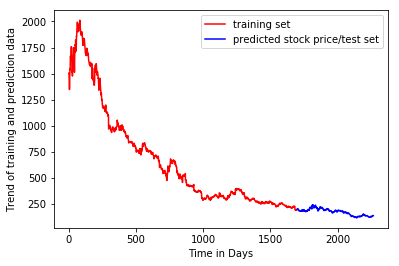

In [94]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()


**We trained our data for the first 1700 or so days and then tested for the rest. The prediction plot has kept up with the pattern how ever not to my satisfaction.**

In [95]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)


Last Day Value: 139.6865234375
Next Day Value: 138.06378173828125


**The value  was found  relying on OHLC values. As the days increase the value is decreasing or rather stabilizing. However this is a wrong way of going about since amazon prices are still booming not decreasing.**

**Next notebook I'll focus on NOT overfitting the model and trying to get more data. Also I'll perform hyperparameter tuning and then try to PREDICT the STOCK PRICE MOVEMENT instead of the prices** 

  Code Ref for LSTM:
  
  https://github.com/LiamConnell/deep-algotrading
  
  https://keras.io/getting-started/sequential-model-guide/

**IN THE NEXT NOTEBOOK I AM GOING TO FOCUS MORE ON NORMALIZATION WITH HYPERPARAMTER TUNING AND LESS ON FEATURE EXTRACTION. THE REASON FOR THIS IS IT LOOKS LIKE A LSTM ESPECIALLY ON KERAS DOESN'T DO A GREAT JOB AT PREDICTING DAY TO DAY VALUES.**

**CONCLUSION FOR THIS NOTEBOOK:**

**1. FEATURES**:

**Focused on feature engineering and made a total of 19 features. Most of them were based on momentum and moving avaerage and EMA. Even Bollinger Bands were calculated**

**2. ARIMA MODEL**

**Got a great ARIMA model with less differemce AIC and BIC and P values close to the coefficient**

**3. FOURIER TRANSFORM MODEL**

**We got great predictions with Fourier Transform very close to the actual values**

**4. FEATURE ENGINEERING WITH XGBOOST**

**Refer to feature extraction graph where features are highest by their closeness to their Closing values. As predicted EMA is pretty high in this feature.** 

**5. LSTM MODEL WITH ONE FEATURE** 

**LSTM model with one feature did NOT give us the predictions we wanted.**

**6. LSTM MODEL WITH MULTIPLE FEATURES**

**LSTM model with multiple features again did not give us predictions we wanted.**

**I have come to the conclusion that LSTMs are not great at predicting Stock Prices when you just input stock price directly but rather better at predicting stock price movement over a long period of time.With the help of these movements we can calclate the price.**

**For this reason  I will use a larger dataset in the next notebook that can be observed for longer time and then predict stock price movement**
 
